# Testing models

In [1]:
# import pandas & numpy library
import pandas as pd
import numpy as np

# imoprt seaborn & matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# import KNN from sklearn
from sklearn.neighbors import KDTree

# shows a bigger plot size for readability 
plt.rcParams['figure.figsize'] = (12, 5)
#improve resolution
%config InlineBackend.figure_format ='retina'


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, confusion_matrix

In [2]:
# read 'songDb.tsv' into dataframe with correct encoding  
music = pd.read_csv('songDb.tsv', sep='\t', encoding='ISO-8859-1')

C:\Users\David Soberanis\AppData\Local\Temp\ipykernel_10292\3079004086.py:2: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  music = pd.read_csv('songDb.tsv', sep='\t', encoding='ISO-8859-1')


# Cleaning and Filtering rows
- gets rid of NaN values
- removes all songs that are not in the top 5 genres
- fixes indexing 
- fixes dtypes

In [3]:
df = music # for testing
temp = df['Genre'].value_counts()
temp[0:10] # show top 10 by count

alternativeamericana    1891
electrolatino           1009
doo-wop                  972
reading                  969
nuelectro                909
groovemetal              903
psychill                 901
deepdeephouse            892
torontoindie             884
newrave                  875
Name: Genre, dtype: int64

In [4]:
df = music # for testing

df = df.rename({'Genre':'genres'}, axis='columns') # rename to match 
df = df.dropna()

# combines subgenres into more general Genres. This function removes all genres outside of the top 5.
# You can alter this to include more than the top 5 genres
def CombineGenre(str_in):

    try:
        str_in = str_in.lower()
        str_in = str_in.strip()
        
        if 'alternativeamericana' in str_in:
            output = 'Alternative'
        elif 'electrolatino' in str_in:
            output = 'Electrolatino'
        elif 'doo-wop' in str_in:
            output = 'Doo-wop'
        elif 'reading' in str_in:
            output = 'Reading'
        elif 'nuelectro' in str_in:
            output = 'Nuelectro'
        elif 'groovemetal' in str_in:
            output = 'Groovemetal'
        elif 'psychill' in str_in:
            output = 'Psychill'
        elif 'deepdeephouse' in str_in:
            output = 'Deepdeephouse'
        elif 'torontoindie' in str_in:
            output = 'Torontoindie'
        elif 'newrave' in str_in:
            output = 'Newrave'
        else:
            output  = np.nan
    except:
        output = np.nan
        
    return output

# applys above function to combine genres
df['genres'] = df['genres'].apply(CombineGenre)
df = df.dropna() # removes all genres that were not combined before 
df = df.reset_index() # resets the index since we removed many rows
# df # shows now filtered df of music
# df['genres'].value_counts() # shows number of songs in each top 5 genres


In [5]:
feature_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
                'Tempo', 'Duration_ms', 'time_signature']

df[feature_cols] = df[feature_cols].astype(np.float64)

# Create Design Matrix and Target vectors from the now filtered Df 

In [6]:
# Start by removing all columns that are not features 

feature_cols = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence',
                'Tempo', 'Duration_ms', 'time_signature']
target_col = 'genres'

X = df[feature_cols]
y = df[target_col]

print(f'Feature cols: {feature_cols}')
print(f'Target: {target_col}')

Feature cols: ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'time_signature']
Target: genres


### Cut down on dimensions

In [7]:
# cut off dimensions to see affect on accuracy
feature_cols = ['Danceability', 'Loudness',
                'Speechness', 'Acousticness', 'Instrumentalness', 'Liveness'
                ]

### Sub Sample the data to 10%

In [8]:
# take a subset of the data 10% OR any other subset

full_data = df[feature_cols + [target_col]]
df_small = full_data.groupby('genres').apply(lambda x: x.sample(frac = 0.1, random_state = 0)).reset_index(
    drop = True)


# This is a small set for testing 
X_small = df_small[feature_cols]
y_small = df_small[target_col]


### Train Test Split

In [9]:
# Create train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, stratify=y_small, test_size=0.2, random_state=42)

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (816, 6)
Testing shape: (204, 6)


# Model Tests

### kNN test

In [10]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

# Label encoder for target (fitting it now to avoid unknown classes or different labels in testing)
le = LabelEncoder().fit(df[target_col].unique())

# KNN transformer and classifier
nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=20, n_jobs = -1)  # default nn=20, testsize=0.1, frac=0.5, cut features set

# Pipelining
nca_pipe = Pipeline([
    ('nca', nca), 
    ('knn', knn)
])

# Fit
nca_pipe.fit(X_train, le.transform(y_train))

# Preliminary score
print(nca_pipe.score(X_test, le.transform(y_test)))

0.3382352941176471
CPU times: total: 5.62 s
Wall time: 3.67 s


### SVM

In [16]:
# SVM code linear
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1) # default linear            Note: testsize = 0.2, fract 0.99 we get 67.5% 
model.fit(X_train, y_train)

model.score(X_test,y_test)

0.35784313725490197

In [13]:
# SVM code rbf
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='rbf', C=1)                    # 
model.fit(X_train, y_train)

model.score(X_test,y_test)

0.24509803921568626

In [76]:
#from sklearn.model_selection import cross_val_score
#cross_score = cross_val_score(model, X, y, cv=5)

In [77]:
#cross_score

### PCA

### Logistic Regression

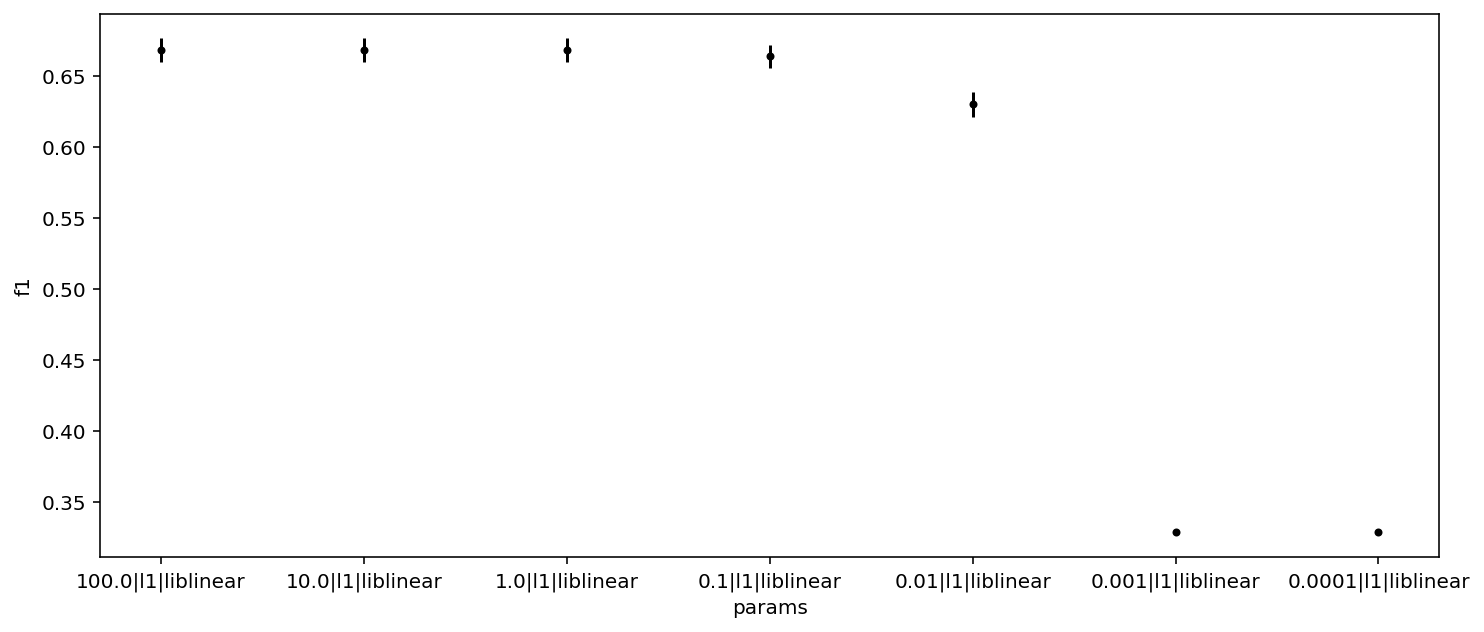

In [73]:
def plot_results(gridsearchcv):
    params = gridsearchcv.cv_results_["params"]
    ys = gridsearchcv.cv_results_["mean_test_score"]
    xs = ['|'.join(str(v) for v in param.values()) for param in params]
    yerr = gridsearchcv.cv_results_["std_test_score"]
    plt.errorbar(xs, ys, yerr / np.sqrt(gridsearchcv.cv), fmt='.k')
    plt.ylabel("f1")
    plt.xlabel("params")
    
def check_for_convergence(gridsearchcv):
    return gridsearchcv.best_estimator_.steps[-1][1].n_iter_ < gridsearchcv.best_estimator_.steps[-1][1].max_iter


np.random.seed(31415) 

scaler = StandardScaler()
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
logistic = LogisticRegression() # first step

# YOUR CODE HERE

pipe = Pipeline(steps=[("scaler", scaler), ("imputer", imp), ("logistic", logistic)])

# you don't need to modify the max_iter param. If you do, keep it under 1000
# hint, prefix your param names with logistic__ to pass it to the logistic step

# this grid when passed to the gridsearch will make a logistic regression 
# if you add more to the param_grid you can compare differnt models and see their IQR
param_grid = { 
    "logistic__C" : 10.0 ** -np.arange(-2, 5),
    "logistic__solver" : ['liblinear'], # use one algo from here it needs to be l1 https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
    "logistic__penalty" : ['l1'] # TA recommends using the l1 penalty 
}

# YOUR CODE HERE

# use f1_micro for scoring
# use 7 folds
gscv = GridSearchCV(pipe, param_grid, scoring = 'f1_micro', cv=7) # GridSearchCV(...)

# YOUR CODE HERE


# gscv.fit(X_train, y_train)
gscv.fit(X_train, y_train)

plot_results(gscv)
